<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 1:
  !mkdir -p data

  !cd data && wget http://images.cocodataset.org/zips/train2017.zip
  !cd data && wget http://images.cocodataset.org/zips/val2017.zip

  !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

  !cd data && unzip -q train2017.zip
  !cd data && unzip -q val2017.zip
  !cd data && unzip -q annotations_trainval2017.zip

--2021-10-20 06:10:33--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.84.220
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.84.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G   107MB/s    in 4m 44s  

2021-10-20 06:15:17 (64.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-10-20 06:15:17--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.128.41
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.128.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.3MB/s    in 8.1s    

2021-10-20 06:15:26 (95.6 MB/s) - ‘v

In [2]:
import json
import pandas as pd
import os

In [3]:
with open("/content/data/annotations/captions_train2017.json", 'rb')  as f:
    capt = json.load(f)

In [4]:
df = pd.DataFrame.from_dict(capt['annotations'])
df.rename(columns={'id':'category_id'}, inplace=True)
df.head()

,image_id,category_id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [5]:
df = df.merge(pd.DataFrame(capt['images'])[['id', 'file_name']], left_on='image_id', right_on='id', how='left')
df.head()

,image_id,category_id,caption,id,file_name
0,203564,37,A bicycle replica with a clock as the front wh...,203564,000000203564.jpg
1,322141,49,A room with blue walls and a white sink and door.,322141,000000322141.jpg
2,16977,89,A car that seems to be parked illegally behind...,16977,000000016977.jpg
3,106140,98,A large passenger airplane flying through the ...,106140,000000106140.jpg
4,106140,101,There is a GOL plane taking off in a partly cl...,106140,000000106140.jpg


In [6]:
df = df[:100000]

In [7]:
all_img_name_vector = (['data/train2017/'] + df['file_name']).tolist()
all_img_name_vector[:10]

['data/train2017/000000203564.jpg',
 'data/train2017/000000322141.jpg',
 'data/train2017/000000016977.jpg',
 'data/train2017/000000106140.jpg',
 'data/train2017/000000106140.jpg',
 'data/train2017/000000322141.jpg',
 'data/train2017/000000322141.jpg',
 'data/train2017/000000322141.jpg',
 'data/train2017/000000203564.jpg',
 'data/train2017/000000016977.jpg']

In [8]:
all_captions = []
for annot in df['caption']:
  caption = '<start> ' + annot + ' <end>'
  all_captions.append(caption)
all_captions[:10]

['<start> A bicycle replica with a clock as the front wheel. <end>',
 '<start> A room with blue walls and a white sink and door. <end>',
 '<start> A car that seems to be parked illegally behind a legally parked car <end>',
 '<start> A large passenger airplane flying through the air. <end>',
 '<start> There is a GOL plane taking off in a partly cloudy sky. <end>',
 '<start> Blue and white color scheme in a small bathroom. <end>',
 '<start> This is a blue and white bathroom with a wall sink and a lifesaver on the wall. <end>',
 '<start> A blue boat themed bathroom with a life preserver on the wall <end>',
 '<start> The bike has a clock as a tire. <end>',
 '<start> two cars parked on the sidewalk on the street <end>']

In [9]:
len(all_img_name_vector), len(all_captions)

(100000, 100000)

In [10]:
import tensorflow as tf

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications import InceptionV3, inception_v3
from tensorflow.data import Dataset, experimental
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import  pad_sequences
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow import nn as tf_K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.train import Checkpoint, CheckpointManager

In [11]:
# Перемешиваем параллельно описания и изображения
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = inception_v3.preprocess_input(img)
    return img, image_path

In [13]:
image_model = InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [14]:
#Найдем максимальную длину описания
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
top_k = 5000
tokenizer = Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [17]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
cap_vector = pad_sequences(train_seqs, padding='post')

In [19]:
#Считаем максимальную длину описаний для дальнейшей отрисовки матриц внимания
max_length = calc_max_length(train_seqs)

In [20]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [21]:
# Возьмем уникальные изображения
encode_train = sorted(set(img_name_vector))


image_dataset = Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=experimental.AUTOTUNE).batch(16) 

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img) 
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

  0%|          | 0/1254 [00:00<?, ?it/s]

In [22]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(80000, 80000, 20000, 20000)

In [23]:
BATCH_SIZE = 512
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Выходная форма фичей из InceptionV3 - (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [24]:
# Функция для загрузки изображений и описаний
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [25]:
dataset = Dataset.from_tensor_slices((img_name_train, cap_train))

# Параллельно обрабатываем данные
dataset = dataset.map(lambda item1, item2: tf.numpy_function( 
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=experimental.AUTOTUNE)

In [26]:
class BahdanauAttention(Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()    
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # форма коэффициентов внимания == (batch_size, 64, 1)
    #
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    #
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
class CNN_Encoder(Model):
    #Наш энкодер будет работать с уже извлеченными фичами, которые были сохранены в файл
    #Поэтому нам остается добавить только полносвязный слой
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()                    
        self.fc = Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN_Decoder(Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()      
    self.units = units

    self.embedding = Embedding(vocab_size, embedding_dim)
    self.gru = GRU(self.units, return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = Dense(self.units)
    self.fc2 = Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)         

  def call(self, x, features, hidden):
    # слой attention является отдельной моделью
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [29]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [30]:
optimizer = Adam()
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [31]:
checkpoint_path = "./checkpoints/train"
ckpt = Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [32]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:                     
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [33]:
#список для значений ошибки
loss_plot = []

In [34]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # обновляем внутреннее состояние декодера
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:                     
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables     

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [35]:
EPOCHS = 200

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9544
Epoch 1 Batch 100 Loss 0.9569
Epoch 1 Loss 1.088823
Time taken for 1 epoch 253.50049304962158 sec

Epoch 2 Batch 0 Loss 0.8651
Epoch 2 Batch 100 Loss 0.7692
Epoch 2 Loss 0.814892
Time taken for 1 epoch 95.28119492530823 sec

Epoch 3 Batch 0 Loss 0.7316
Epoch 3 Batch 100 Loss 0.7208
Epoch 3 Loss 0.732493
Time taken for 1 epoch 95.15065741539001 sec

Epoch 4 Batch 0 Loss 0.6967
Epoch 4 Batch 100 Loss 0.6849
Epoch 4 Loss 0.690427
Time taken for 1 epoch 95.11446690559387 sec

Epoch 5 Batch 0 Loss 0.6656
Epoch 5 Batch 100 Loss 0.6611
Epoch 5 Loss 0.662064
Time taken for 1 epoch 95.10736393928528 sec

Epoch 6 Batch 0 Loss 0.6355
Epoch 6 Batch 100 Loss 0.6138
Epoch 6 Loss 0.640297
Time taken for 1 epoch 95.15289306640625 sec

Epoch 7 Batch 0 Loss 0.6145
Epoch 7 Batch 100 Loss 0.5954
Epoch 7 Loss 0.621851
Time taken for 1 epoch 95.08354234695435 sec

Epoch 8 Batch 0 Loss 0.6055
Epoch 8 Batch 100 Loss 0.6038
Epoch 8 Loss 0.605852
Time taken for 1 epoch 94.99604773521

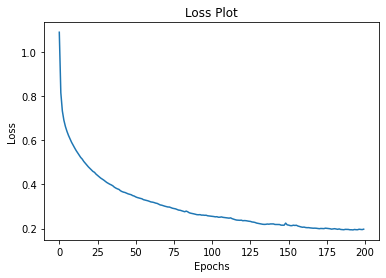

In [36]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [37]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [38]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()
    plt.imshow(temp_image)

Real Caption: <start> a bicycle and a motorcycle are parked next to each other at a park <end>
Prediction Caption: a motorcycle on a street by a giant kite <end>


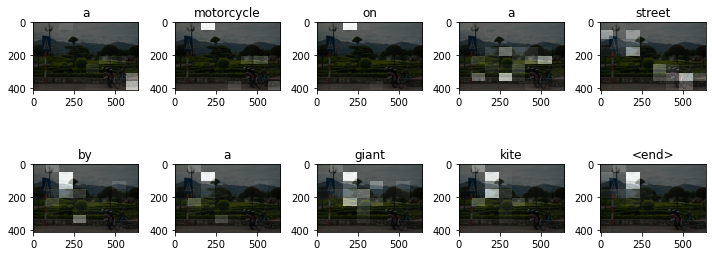

Real Caption: <start> a dated kitchen reveals a wall hung faucet under a closed off window <end>
Prediction Caption: an empty kitchen with lots of a sink and a sink <end>


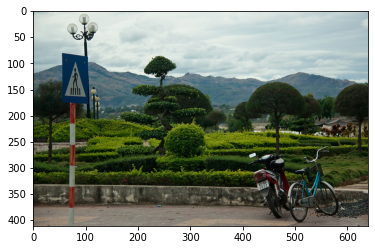

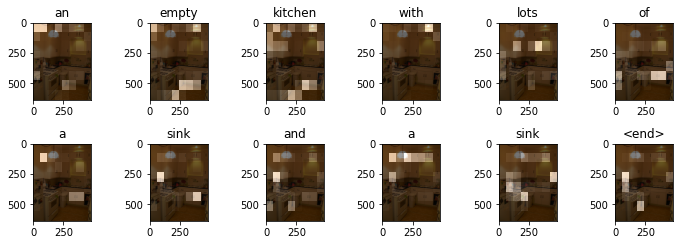

Real Caption: <start> this is a photo of people from the royal family <end>
Prediction Caption: a couple of england and prince <unk> <unk> <end>


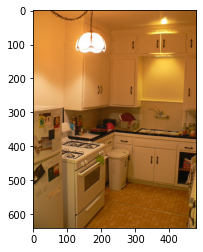

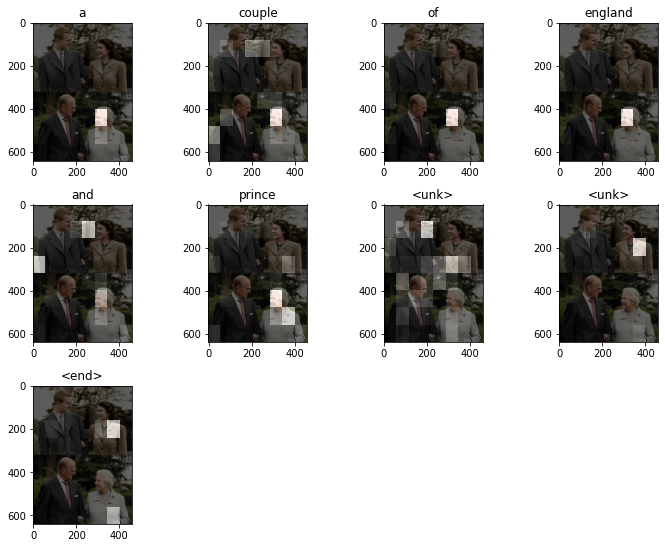

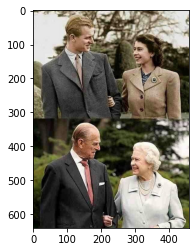

In [39]:
for i in range(3):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)